# Neural Networks Practical Workshop - Part 3: MNIST Dataset

In this notebook, we'll explore the MNIST dataset, which is a widely-used collection of handwritten digits. It's often used as a benchmark for image classification algorithms.

## 1. Setup and Imports

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 2. Loading the MNIST Dataset

We'll use PyTorch's torchvision library to download and load the MNIST dataset.

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 60000
Test dataset size: 10000


## 3. Exploring the MNIST Dataset

Batch shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
Sample image shape: torch.Size([1, 28, 28])


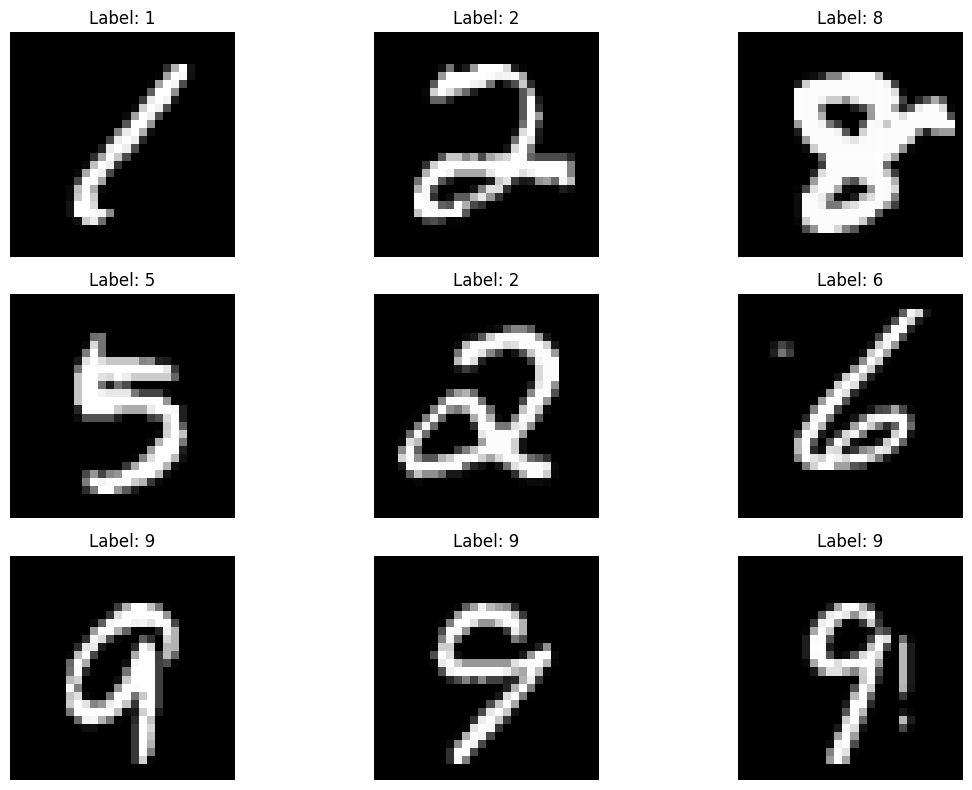

In [3]:
# Get a batch of training data
examples = iter(train_loader)
images, labels = next(examples)

# Print shape information
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Sample image shape: {images[0].shape}")

# Display a few examples
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Distribution of Digits in the Dataset

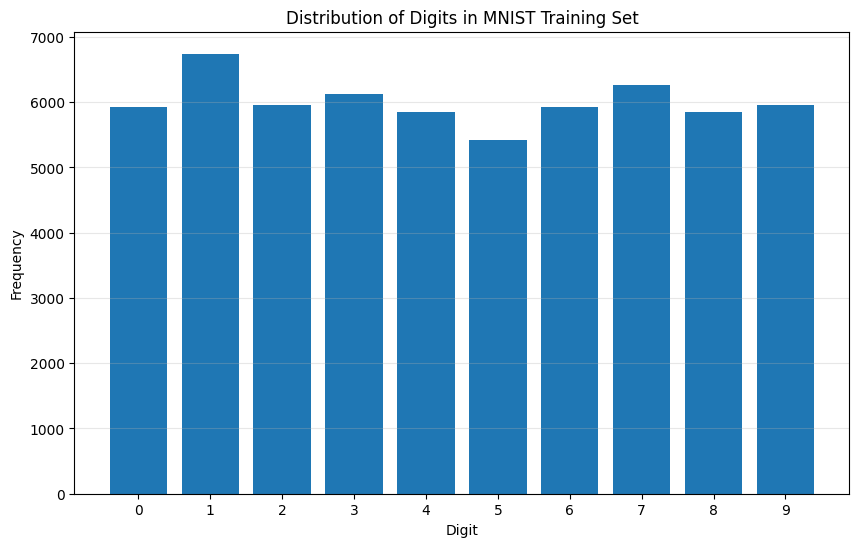

Digit distribution in the training set:
Digit 0: 5923 images (9.87%)
Digit 1: 6742 images (11.24%)
Digit 2: 5958 images (9.93%)
Digit 3: 6131 images (10.22%)
Digit 4: 5842 images (9.74%)
Digit 5: 5421 images (9.04%)
Digit 6: 5918 images (9.86%)
Digit 7: 6265 images (10.44%)
Digit 8: 5851 images (9.75%)
Digit 9: 5949 images (9.92%)


In [4]:
# Count digit occurrences in training set
digit_counts = np.zeros(10)
for _, labels in train_loader:
    for label in labels:
        digit_counts[label.item()] += 1

# Plot distribution
plt.figure(figsize=(10, 6))
plt.bar(range(10), digit_counts)
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Distribution of Digits in MNIST Training Set')
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Digit distribution in the training set:")
for digit in range(10):
    print(f"Digit {digit}: {int(digit_counts[digit])} images ({digit_counts[digit]/sum(digit_counts)*100:.2f}%)")

## 5. Visualizing Image Properties

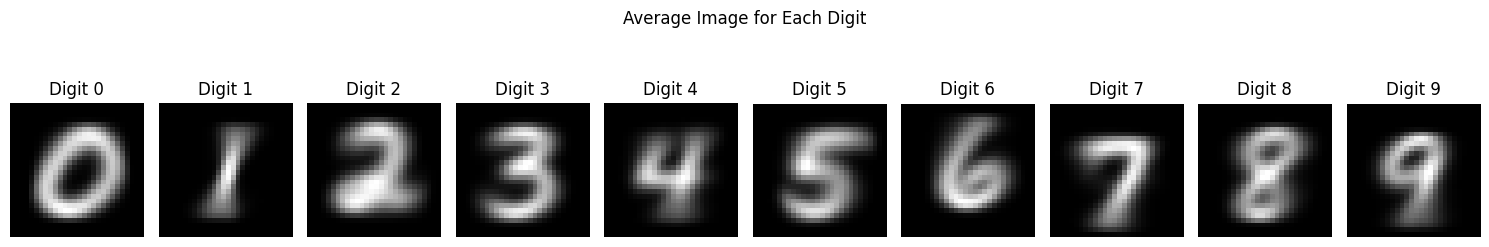

In [5]:
# Compute average image for each digit
avg_images = np.zeros((10, 28, 28))
counts = np.zeros(10)

for images, labels in train_loader:
    for image, label in zip(images, labels):
        avg_images[label.item()] += image[0].numpy()
        counts[label.item()] += 1

# Normalize by count
for digit in range(10):
    avg_images[digit] /= counts[digit]

# Display average images
plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(avg_images[i], cmap='gray')
    plt.title(f'Digit {i}')
    plt.axis('off')
plt.suptitle('Average Image for Each Digit')
plt.tight_layout()
plt.show()

## 6. Preparing Data for Custom Neural Network

To use our custom neural network implementation from the previous notebook, we need to flatten the images and prepare them in a format compatible with our implementation.

Training subset shape: (5000, 784)
Training labels shape: (5000,)
Test subset shape: (1000, 784)
Test labels shape: (1000,)


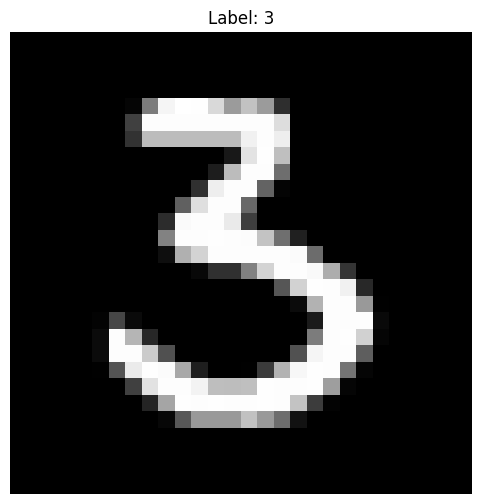

In [6]:
# Extract a subset of MNIST for faster training with our custom model
def get_mnist_subset(loader, num_samples):
    samples = []
    labels = []
    samples_count = 0
    
    for images, batch_labels in loader:
        # Flatten the images
        batch_size = images.size(0)
        flattened_images = images.view(batch_size, -1).numpy()
        batch_labels_np = batch_labels.numpy()
        
        # Add to our collection
        samples.append(flattened_images)
        labels.append(batch_labels_np)
        
        # Update count
        samples_count += batch_size
        if samples_count >= num_samples:
            break
    
    # Combine all batches
    X = np.vstack(samples)[:num_samples]
    y = np.concatenate(labels)[:num_samples]
    
    return X, y

# Get a subset of 5000 training examples and 1000 test examples
X_train_subset, y_train_subset = get_mnist_subset(train_loader, 5000)
X_test_subset, y_test_subset = get_mnist_subset(test_loader, 1000)

print(f"Training subset shape: {X_train_subset.shape}")
print(f"Training labels shape: {y_train_subset.shape}")
print(f"Test subset shape: {X_test_subset.shape}")
print(f"Test labels shape: {y_test_subset.shape}")

# Display a sample image from the flattened data
plt.figure(figsize=(6, 6))
plt.imshow(X_train_subset[0].reshape(28, 28), cmap='gray')
plt.title(f'Label: {y_train_subset[0]}')
plt.axis('off')
plt.show()

## 7. Data Augmentation

Let's explore how data augmentation can be used to artificially expand the training dataset.

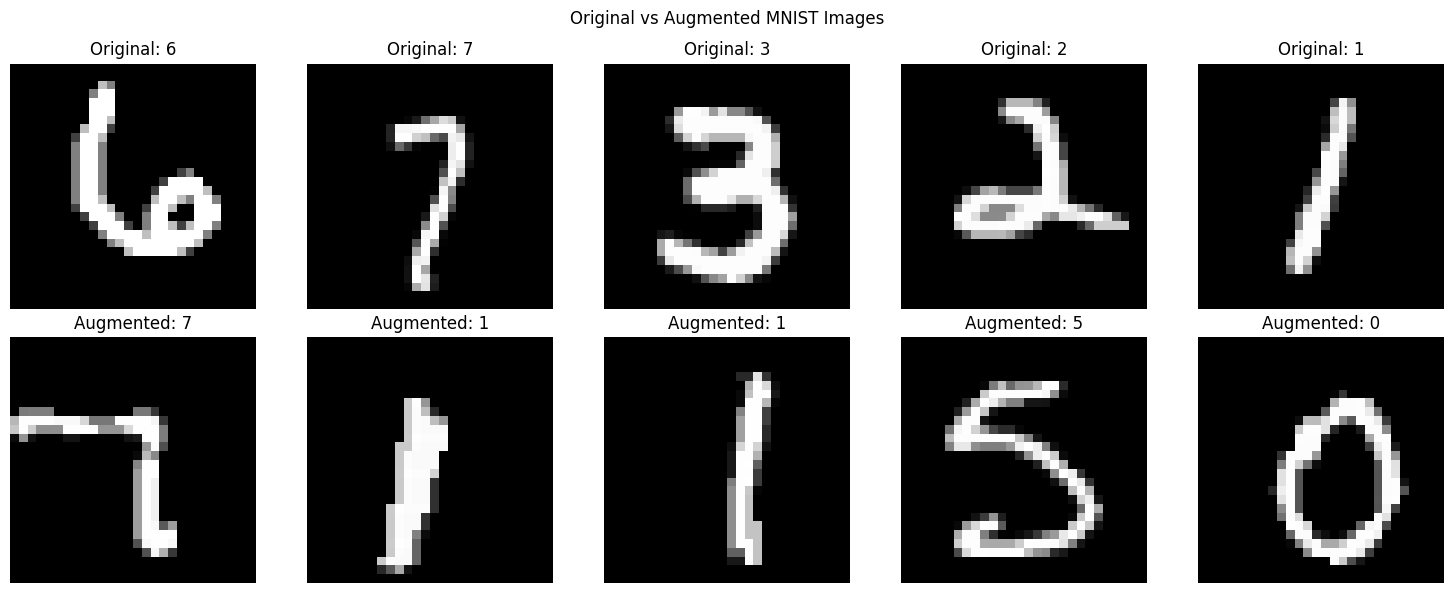

In [7]:
# Define augmentation transformations
augmentation_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Create a dataset with augmentations
train_dataset_aug = datasets.MNIST('./data', train=True, download=True, transform=augmentation_transform)

# Create a loader to visualize the augmented data
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)

# Get a batch of original and augmented data
orig_examples = iter(train_loader)
aug_examples = iter(train_loader_aug)
orig_images, orig_labels = next(orig_examples)
aug_images, aug_labels = next(aug_examples)

# Display comparison
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original images
    axes[0, i].imshow(orig_images[i][0], cmap='gray')
    axes[0, i].set_title(f'Original: {orig_labels[i]}')
    axes[0, i].axis('off')
    
    # Augmented images
    axes[1, i].imshow(aug_images[i][0], cmap='gray')
    axes[1, i].set_title(f'Augmented: {aug_labels[i]}')
    axes[1, i].axis('off')

plt.suptitle('Original vs Augmented MNIST Images')
plt.tight_layout()
plt.show()

## 8. Creating a Balanced Mini-Dataset for Experimentation

For experimentation and fast prototyping, let's create a small, balanced dataset with an equal number of images per digit.

Mini train set shape: (500, 784)
Mini test set shape: (200, 784)


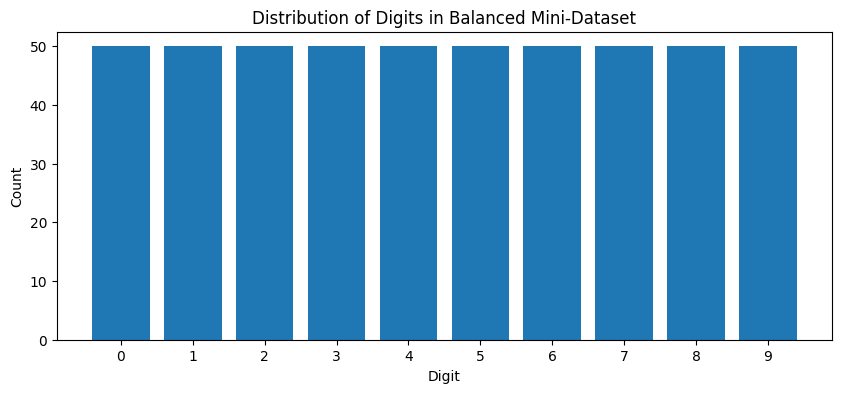

In [8]:
# Create a balanced mini-dataset
def create_balanced_mini_dataset(loader, samples_per_class=50):
    X = []
    y = []
    counts = np.zeros(10, dtype=int)
    
    for images, labels in loader:
        batch_size = images.size(0)
        flattened_images = images.view(batch_size, -1).numpy()
        
        for i in range(batch_size):
            label = labels[i].item()
            if counts[label] < samples_per_class:
                X.append(flattened_images[i])
                y.append(label)
                counts[label] += 1
        
        if np.min(counts) >= samples_per_class:
            break
    
    return np.array(X), np.array(y)

# Create balanced mini-datasets for training and testing
X_mini_train, y_mini_train = create_balanced_mini_dataset(train_loader, samples_per_class=50)
X_mini_test, y_mini_test = create_balanced_mini_dataset(test_loader, samples_per_class=20)

print(f"Mini train set shape: {X_mini_train.shape}")
print(f"Mini test set shape: {X_mini_test.shape}")

# Visualize the distribution
unique, counts = np.unique(y_mini_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique, counts)
plt.title('Distribution of Digits in Balanced Mini-Dataset')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.xticks(range(10))
plt.show()

## 9. Save the Prepared Data

Let's save our prepared datasets so they can be easily loaded in the subsequent notebooks.

In [9]:
# Create a directory to save our data
import os
if not os.path.exists('./processed_data'):
    os.makedirs('./processed_data')

# Save our prepared datasets
np.savez('./processed_data/mnist_subset.npz', 
         X_train=X_train_subset, y_train=y_train_subset,
         X_test=X_test_subset, y_test=y_test_subset)

np.savez('./processed_data/mnist_mini.npz',
         X_train=X_mini_train, y_train=y_mini_train,
         X_test=X_mini_test, y_test=y_mini_test)

print("Datasets saved to 'processed_data' directory")

Datasets saved to 'processed_data' directory


## 10. Visualization of Image Features

Let's visualize some features of the MNIST images to better understand the data.

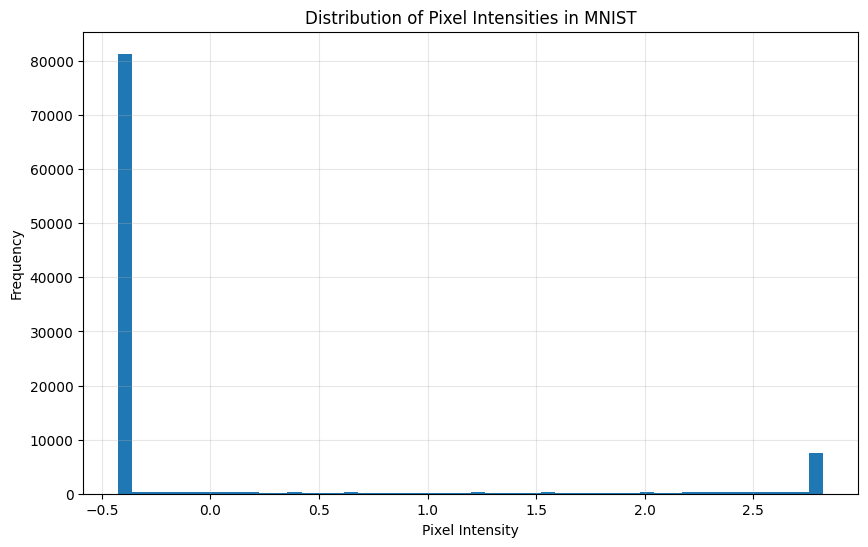

In [10]:
# Calculate pixel intensity distribution
pixel_values = []
for images, _ in train_loader:
    # Add pixel values from this batch
    pixel_values.extend(images.numpy().flatten())
    # Limit the number of batches to process
    if len(pixel_values) > 100000:  # sample about 100k pixels
        break
pixel_values = np.array(pixel_values)

# Plot histogram of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=50)
plt.title('Distribution of Pixel Intensities in MNIST')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

## 11. Visualize Difficult Examples

Let's find and visualize some examples that might be difficult for a model to classify correctly.

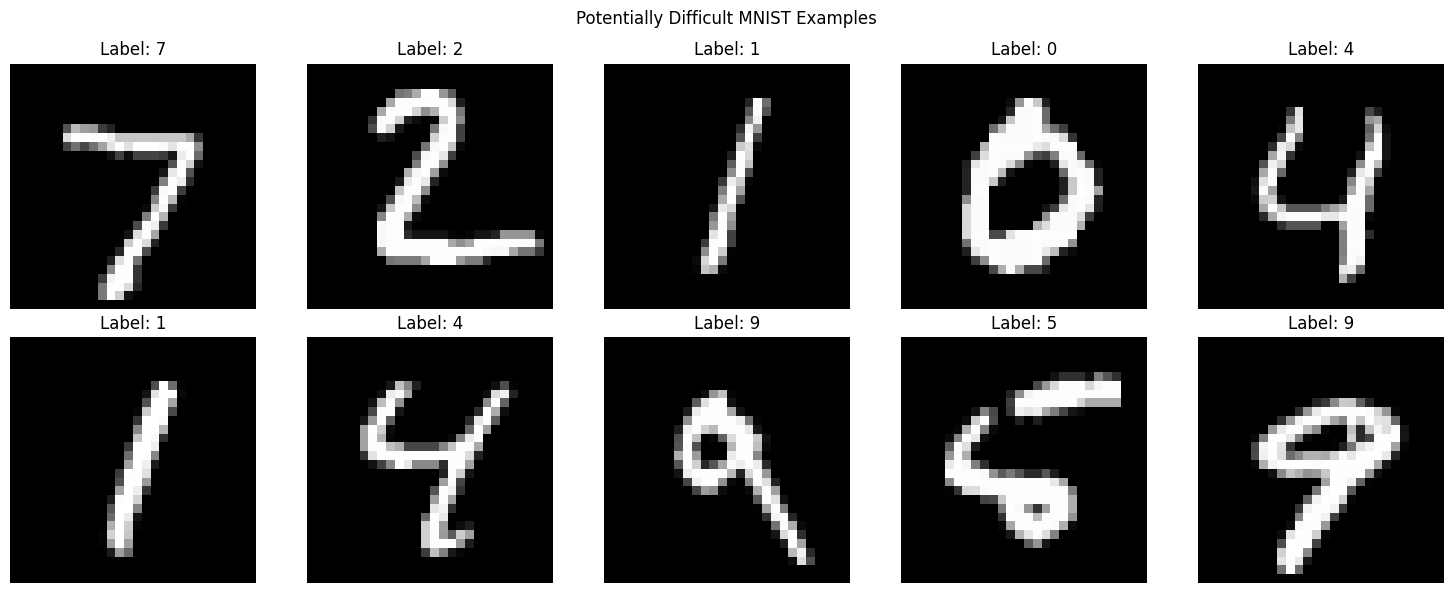

In [11]:
# Function to find images with minimal black pixels (potentially harder to classify)
def find_difficult_examples(loader, num_examples=10):
    difficult_images = []
    difficult_labels = []
    pixel_counts = []  # Lower count = fewer dark pixels = potentially harder
    
    for images, labels in loader:
        for i in range(images.size(0)):
            # Count darker pixels (below a threshold)
            img = images[i][0].numpy()
            # Calculate the number of pixels with intensity < -0.5 after normalization
            dark_pixel_count = np.sum(img < -0.5)
            
            # If we don't have enough examples yet or this one has fewer dark pixels
            if len(difficult_images) < num_examples:
                difficult_images.append(img)
                difficult_labels.append(labels[i].item())
                pixel_counts.append(dark_pixel_count)
            elif dark_pixel_count < max(pixel_counts):
                # Replace the example with the highest pixel count
                max_idx = pixel_counts.index(max(pixel_counts))
                difficult_images[max_idx] = img
                difficult_labels[max_idx] = labels[i].item()
                pixel_counts[max_idx] = dark_pixel_count
    
    return difficult_images, difficult_labels

# Find potentially difficult examples
difficult_images, difficult_labels = find_difficult_examples(test_loader)

# Display the difficult examples
plt.figure(figsize=(15, 6))
for i in range(len(difficult_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(difficult_images[i], cmap='gray')
    plt.title(f'Label: {difficult_labels[i]}')
    plt.axis('off')
plt.suptitle('Potentially Difficult MNIST Examples')
plt.tight_layout()
plt.show()

## Next Steps

Now that we've explored the MNIST dataset and prepared it for use with our models, let's move on to the next notebook, `04_pytorch_implementation.ipynb`, where we'll implement a neural network using PyTorch to recognize handwritten digits.